# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [7]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(30),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(15),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 14, 26, 26]             126
              ReLU-2           [-1, 14, 26, 26]               0
       BatchNorm2d-3           [-1, 14, 26, 26]              28
           Dropout-4           [-1, 14, 26, 26]               0
            Conv2d-5           [-1, 30, 24, 24]           3,780
              ReLU-6           [-1, 30, 24, 24]               0
       BatchNorm2d-7           [-1, 30, 24, 24]              60
           Dropout-8           [-1, 30, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             300
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # Validate the 
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.17251162230968475 Batch_id=468 Accuracy=83.97: 100%|██████████████████████████| 469/469 [00:09<00:00, 51.63it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0925, Accuracy: 9755/10000 (97.55%)

EPOCH: 1


Loss=0.07677697390317917 Batch_id=468 Accuracy=97.02: 100%|██████████████████████████| 469/469 [00:09<00:00, 51.71it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0502, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.04540793597698212 Batch_id=468 Accuracy=97.83: 100%|██████████████████████████| 469/469 [00:09<00:00, 50.77it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0449, Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.023897869512438774 Batch_id=468 Accuracy=98.08: 100%|█████████████████████████| 469/469 [00:09<00:00, 51.58it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.038642775267362595 Batch_id=468 Accuracy=98.37: 100%|█████████████████████████| 469/469 [00:09<00:00, 50.81it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.03048570267856121 Batch_id=468 Accuracy=98.38: 100%|██████████████████████████| 469/469 [00:09<00:00, 51.26it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.043220292776823044 Batch_id=468 Accuracy=98.55: 100%|█████████████████████████| 469/469 [00:09<00:00, 50.49it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9920/10000 (99.20%)

EPOCH: 7


Loss=0.03372243791818619 Batch_id=468 Accuracy=98.64: 100%|██████████████████████████| 469/469 [00:09<00:00, 51.84it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.027901366353034973 Batch_id=468 Accuracy=98.65: 100%|█████████████████████████| 469/469 [00:09<00:00, 51.12it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.1142730787396431 Batch_id=468 Accuracy=98.63: 100%|███████████████████████████| 469/469 [00:09<00:00, 50.68it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.02570470981299877 Batch_id=468 Accuracy=98.71: 100%|██████████████████████████| 469/469 [00:09<00:00, 50.43it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.031697433441877365 Batch_id=468 Accuracy=98.76: 100%|█████████████████████████| 469/469 [00:09<00:00, 51.03it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.06952983886003494 Batch_id=468 Accuracy=98.84: 100%|██████████████████████████| 469/469 [00:09<00:00, 51.17it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.02102598547935486 Batch_id=468 Accuracy=98.75: 100%|██████████████████████████| 469/469 [00:09<00:00, 51.42it/s]
  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.17487113177776337 Batch_id=468 Accuracy=98.92: 100%|██████████████████████████| 469/469 [00:09<00:00, 51.67it/s]



Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

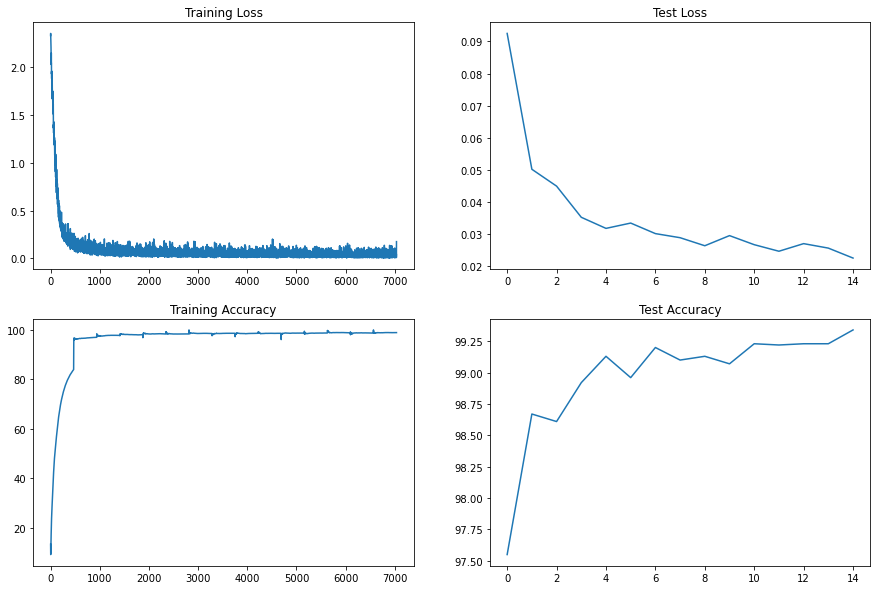

In [11]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Observations
### Target
1. Add Transformations
2. Reduce the parameters 

### Result 
1. Parameters : 9707
2. Good Train and Test Accuracy : 98.92 and 99.34%.

### Analysis
1. Model is Overfitting

### Model Used


In_channels Output_channels Kernel_Size

## 1. Convolution Block 1
Conv2D:  1, 14, 3  Output: 26x26x14

Conv2D: 14, 30, 3  Output: 24x24x30

## 2. Transition Block(Covolution+Max Pool)
Conv2D: 30, 10, 1 Output: 24x24x10 

MaxPool2D: 2x2    Output: 12x12x10

## 3. Convolution Block 2
Conv2D: 10, 14, 3 Output: 10x10x14

Conv2D: 14, 15, 3 Output: 8x8x15

Conv2D: 15, 15, 3 Output: 6x6x15


## 4. Global Average Pooling
AvgPool2D: 6x6     Output: 1x1x15

Conv2D: 15, 10, 1  Output: 1x1x10
